# DQN Sort

## Name : 藤原 大悟
## Student Number : 6930-31-6255

##### Formulation

数字列の昇順ソートタスク

状態 $s_t$ ： N桁の0~9の数字($x_1,x_2,\dots,x_N$)の列(ただし0が先頭でも良いこととした)

行動 $a_t$ ： 数字の隙間(i=1~N-1)に対し，その両隣の数字を交換する操作．　確率1で交換後の一つの数字列を観測する．

報酬 $r_t$ : 数列の昇順ソートに成功すると+1, それ以外の場合は一回の操作ごとに$-\frac{2}{N(N-1)}$(罰則)

ニューロン数が$N$である隠れ層を二つ有する4層のニューラルネットワークでDQN強化学習を行う．
入力を状態$s_t$，出力を各行動$a_t$ の有する価値としてQ関数のニューラルネットワークによる近似を行う．

誤差はTD誤差
$$TDError=y_t-Q_\theta(s_t,a_t)$$

$$y_t=\left\{\begin{aligned} &r_t\quad&s_{t+1}\text{が終端状態} \\ &{r_t}+\max_{a'}\hat Q_{\overline \theta}(s_{t+1},a')\quad&\text{otherwise}  \end{aligned} \right. $$
を用い，これに対しHuberLossを考えた．

ターゲットネットワークの更新頻度Bを1024とした．

ミニバッチサイズを16，キューのサイズを1000としてExperience Replayを適用した．

最適化手法はAdamを採用した．

$\epsilon$-greedy法のパラメータ$\epsilon$は初期値を0.5とし，以降指数的に各エポックごとに減衰し，0に向かうようにした．

学習の開始は更新回数がA=1000を超えてからとした．

N=4とした

# Implementation

Tensorflowを用いて実装を行なった

In [1]:
import matplotlib.pyplot as plt
from collections import deque
import tensorflow as tf
import numpy as np
import math
from scipy.stats import multivariate_normal as multi_gauss
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

/Users/daigofujiwara/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/daigofujiwara/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/daigofujiwara/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/daigofujiwara/anaconda3/lib/python3.7/site-packages

In [2]:
class DQN_SORT:
    def __init__(self,inputnum):
        self.N=inputnum
        #隠れ層1のニューロン数
        self.M=128
        #隠れ層2のニューロン数
        self.L=16
        #行動数
        self.Nact=self.N-1
        #ミニバッチ数
        self.minibatch_size = 32
        #キューのサイズ
        self.replay_memory_size = 10000
        self.epsilon=1
        # replay memory
        self.P = deque(maxlen=self.replay_memory_size)

        # model
        self.init_model()

        # variables
        self.current_loss = 0.0
    
    
    def init_model(self):
        # （0） 入力文字列
        self.x = tf.placeholder(tf.float32, [None, self.N],name='x')

        # （1） サイズ変更
        x1 = tf.reshape(self.x, [-1,self.N])

        # （2） 隠れ層1
        # 重みとバイアス
        self.w1 = tf.Variable(tf.truncated_normal([self.N,self.M],stddev=0.01))
        self.b1 = tf.Variable(tf.zeros([self.M]))
        x2 = tf.nn.relu( tf.matmul(x1, self.w1) + self.b1)

        # (3） 隠れ層2
        # 重みとバイアス
        self.w2 = tf.Variable(tf.truncated_normal([self.M,self.L],stddev=0.01))
        self.b2 = tf.Variable(tf.zeros([self.L]))
        x3 = tf.nn.relu( tf.matmul(x2,self.w2) + self.b2)

        # (3） 出力層
        # 重みとバイアス
        self.w3 = tf.Variable(tf.truncated_normal([self.L,self.Nact],stddev=0.01))
        self.b3 = tf.Variable(tf.zeros([self.Nact]))
        self.Qs = tf.matmul(x3, self.w3) + self.b3


        ##target network                  
        # （0） 入力文字列
        self.xtar = tf.placeholder(tf.float32, [None, self.N],name='x')

        # （1） サイズ変更
        x1tar = tf.reshape(self.xtar, [-1,self.N])

       # （2） 隠れ層1
        # 重みとバイアス
        self.w1tar = tf.Variable(tf.truncated_normal([self.N,self.M],stddev=0.01))
        self.b1tar = tf.Variable(tf.zeros([self.M]))
        x2tar = tf.nn.relu( tf.matmul(x1tar, self.w1tar) + self.b1tar)

        # (3） 隠れ層2
        # 重みとバイアス
        self.w2tar = tf.Variable(tf.truncated_normal([self.M,self.L],stddev=0.01))
        self.b2tar = tf.Variable(tf.zeros([self.L]))
        x3tar = tf.nn.relu( tf.matmul(x2tar, self.w2tar) + self.b2tar)

        # (3） 出力層
        # 重みとバイアス
        self.w3tar = tf.Variable(tf.truncated_normal([self.L,self.Nact],stddev=0.01))
        self.b3tar = tf.Variable(tf.zeros([self.Nact]))
        self.Qstar = tf.matmul(x3tar, self.w3tar) + self.b3tar


        # 損失関数
        self.y = tf.placeholder(tf.float32, [None])#バッチサイズ分の長さをもつ
        self.act_indices=tf.placeholder(tf.int32, [None,2])#選択アクションを含むindex
        self.Q= tf.gather_nd(self.Qs,self.act_indices)#バッチサイズ分の長さをもつQ値

        self.loss = tf.reduce_mean(tf.losses.huber_loss(self.y,self.Q))

        # train operation
        optimizer = tf.train.AdamOptimizer()
        self.training = optimizer.minimize(self.loss)

        # session
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())
                          
    def Qs_func(self, state):
        res=self.sess.run(self.Qs, feed_dict={self.x: [state]})
        return res[0]
                            
    def Qstar_func(self,state):
        res=self.sess.run(self.Qstar, feed_dict={self.xtar: [state]})
        return res[0]
    
    def target_update(self):
        tf.assign(self.w1tar,self. w1)
        tf.assign(self.b1tar, self.b1)
        tf.assign(self.w2tar, self.w2)
        tf.assign(self.b2tar, self.b2)
        tf.assign(self.w3tar, self.w3)
        tf.assign(self.b3tar, self.b3)
         
    def select_action(self, state):
        if np.random.rand() <= self.epsilon:
            # random
            return np.random.randint(self.Nact)
        else:
            # max_action Q(state, action)
            return np.argmax(self.Qs_func(state))

    def store_experience(self, state, action, reward, state_1, terminal):
        self.P.append((state, action, reward, state_1, terminal))
                          
    def experience_replay(self):
        state_minibatch = []
        y_minibatch = []
        act_indices=[]
        index=0
        
        # sample random minibatch
        # キューに十分にたまるまでは全部使う
        minibatch_size = min(len(self.P), self.minibatch_size)
        minibatch_indexes = np.random.choice(np.arange(len(self.P)), minibatch_size,replace=False)

        for j in minibatch_indexes:
            state_j, action_j, reward_j, state_j_1, terminal = self.P[j]

            y_j= 0

            if terminal:
                y_j= reward_j
            else:
                y_j= reward_j + np.max(self.Qstar_func(state_j_1)) 

            state_minibatch.append(state_j)
            y_minibatch.append(y_j)
            act_indices.append([index,action_j])
            index+=1
        
        # training
        self.sess.run(self.training, feed_dict={self.x: state_minibatch, self.y: y_minibatch, self.act_indices: act_indices})

        # for log
        self.current_loss = self.sess.run(self.loss, feed_dict={self.x: state_minibatch, self.y: y_minibatch,self.act_indices: act_indices})

In [3]:
class StateArray:
    def __init__(self,N):
        self.N=N
        self.arr=np.random.randint(0,9,N)
        self.frame=0
    
    def excute_action(self,action):
        temp=self.arr[action]
        self.arr[action]=self.arr[action+1]
        self.arr[action+1]=temp
        
    def is_sorted(self):
        res=True
        for i in range(self.N-1):
            res=(self.arr[i]<=self.arr[i+1]) and res
        return res
        
    def observe(self):
        self.reward=-1*2/(self.N*(self.N-1))
        self.terminal=False
        if self.is_sorted():
            self.reward=1
            self.terminal=True
        return self.arr,self.reward,self.terminal

In [4]:
# parameters
n_epochs = 1000

decrese=0.01**(1/n_epochs)

N=4

dqn = DQN_SORT(N)

dqn.target_update()

A=4096
B=1024

count=0

learning_curve=[]
average=0.0
buff=3

for e in range(n_epochs):
    # reset
    frame=0
    cum_reward=0.0
    sa=StateArray(N)
    state_t_1,reward_t,terminal=sa.observe()
    
    while not terminal:
        state_t = state_t_1

        # execute action in environment
        action_t = dqn.select_action(state_t)
        sa.excute_action(action_t)

        # observe environment
        state_t_1, reward_t, terminal = sa.observe()

        # store experience
        dqn.store_experience(state_t, action_t, reward_t, state_t_1, terminal)
        
        # experience replay
        if count>A:
            dqn.experience_replay()
            
        if count%B==0:
            dqn.target_update()


        cum_reward+=reward_t
        average+=cum_reward
        
        if frame%buff==buff-1:
            average/=buff
            learning_curve.append([count,average])
            
        count+=1
        frame+=1

    dqn.epsilon*=decrese
    if e%10==0 and count>A:
        print("epoch=",e,"loss=",dqn.current_loss)
    
print("finished")
learning_curve=np.array(learning_curve)
learning_curve=learning_curve.T

W0822 00:17:49.041315 4551312832 deprecation.py:323] From /Users/daigofujiwara/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/losses/losses_impl.py:121: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


epoch= 130 loss= 0.020253576
epoch= 140 loss= 0.040026892
epoch= 150 loss= 0.00017973615
epoch= 160 loss= 0.00067663216
epoch= 170 loss= 0.040399548
epoch= 180 loss= 0.020094583
epoch= 190 loss= 0.020546423
epoch= 200 loss= 0.0004244889
epoch= 210 loss= 0.020345312
epoch= 220 loss= 0.02013647
epoch= 230 loss= 0.020591661
epoch= 240 loss= 0.020447496
epoch= 250 loss= 0.00011484271
epoch= 260 loss= 3.1665324e-05
epoch= 270 loss= 6.4813554e-05
epoch= 280 loss= 0.00016293337
epoch= 290 loss= 2.1009486e-05
epoch= 300 loss= 0.020465702
epoch= 310 loss= 4.7157646e-06
epoch= 320 loss= 7.448766e-06
epoch= 330 loss= 3.245799e-05
epoch= 340 loss= 1.230831e-05
epoch= 350 loss= 9.151255e-06
epoch= 360 loss= 7.9681695e-06
epoch= 370 loss= 2.7528145e-05
epoch= 380 loss= 1.426253e-05
epoch= 390 loss= 0.020731725
epoch= 400 loss= 8.2652095e-06
epoch= 410 loss= 2.8631846e-05
epoch= 420 loss= 0.02074893
epoch= 430 loss= 2.2729339e-05
epoch= 440 loss= 3.9515897e-05
epoch= 450 loss= 1.2407547e-05
epoch= 46

# Plot Learning Curve

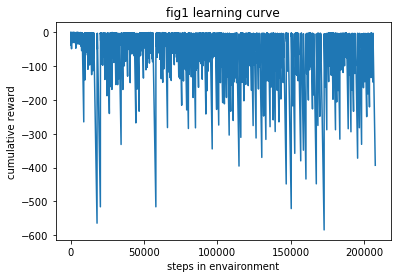

In [5]:
plt.title("fig1 learning curve")
plt.xlabel("steps in envaironment")
plt.ylabel("cumulative reward")
plt.plot(learning_curve[0],learning_curve[1])
plt.show()

 # Conclusion
 
 急激に値が上昇している点はエポックの移り変わりを示すが，むしろ学習初期の方がエポック間のstep数が少ない(=ソートが早く終わっている)ことがわかる．学習がうまくいっていないようである．残念ながらレポート提出までに適切なパラメータを見つけることができなかった．

# Advance

N-1個の行動に加えて，自らタスクを終了させる行動を加え，終了時点で正しくソートできていれば報酬を+1,できていなければ報酬を+0.

In [6]:
class DQN_SORT_ADV:
    def __init__(self,inputnum):
        self.N=inputnum
        #隠れ層1のニューロン数
        self.M=100
        #隠れ層2のニューロン数
        self.L=100
        #行動数
        self.Nact=self.N
        #ミニバッチ数
        self.minibatch_size = 32
        #キューのサイズ
        self.replay_memory_size = 10000
        self.epsilon=0.8
        # replay memory
        self.P = deque(maxlen=self.replay_memory_size)

        # model
        self.init_model()

        # variables
        self.current_loss = 0.0
    
    
    def init_model(self):
        # （0） 入力文字列
        self.x = tf.placeholder(tf.float32, [None, self.N],name='x')

        # （1） サイズ変更
        x1 = tf.reshape(self.x, [-1,self.N])

        # （2） 隠れ層1
        # 重みとバイアス
        self.w1 = tf.Variable(tf.truncated_normal([self.N,self.M],stddev=0.01))
        self.b1 = tf.Variable(tf.zeros([self.M]))
        x2 = tf.nn.relu( tf.matmul(x1, self.w1) + self.b1)

        # (3） 隠れ層2
        # 重みとバイアス
        self.w2 = tf.Variable(tf.truncated_normal([self.M,self.L],stddev=0.01))
        self.b2 = tf.Variable(tf.zeros([self.L]))
        x3 = tf.nn.relu( tf.matmul(x2,self.w2) + self.b2)

        # (3） 出力層
        # 重みとバイアス
        self.w3 = tf.Variable(tf.truncated_normal([self.L,self.Nact],stddev=0.01))
        self.b3 = tf.Variable(tf.zeros([self.Nact]))
        self.Qs = tf.matmul(x3, self.w3) + self.b3


        ##target network                  
        # （0） 入力文字列
        self.xtar = tf.placeholder(tf.float32, [None, self.N],name='x')

        # （1） サイズ変更
        x1tar = tf.reshape(self.xtar, [-1,self.N])

       # （2） 隠れ層1
        # 重みとバイアス
        self.w1tar = tf.Variable(self.w1)
        self.b1tar = tf.Variable(self.b1)
        x2tar = tf.nn.relu( tf.matmul(x1tar, self.w1tar) + self.b1tar)

        # (3） 隠れ層2
        # 重みとバイアス
        self.w2tar = tf.Variable(self.w2)
        self.b2tar = tf.Variable(self.b2)
        x3tar = tf.nn.relu( tf.matmul(x2tar, self.w2tar) + self.b2tar)

        # (3） 出力層
        # 重みとバイアス
        self.w3tar = tf.Variable(self.w3)
        self.b3tar = tf.Variable(self.b3)
        self.Qstar = tf.matmul(x3tar, self.w3tar) + self.b3tar


        # 損失関数
        self.y = tf.placeholder(tf.float32, [None])#バッチサイズ分の長さをもつ
        self.act_indices=tf.placeholder(tf.int32, [None,2])#選択アクションを含むindex
        self.Q= tf.gather_nd(self.Qs,self.act_indices)#バッチサイズ分の長さをもつQ値

        self.loss = tf.reduce_mean(tf.losses.huber_loss(self.y,self.Q))

        # train operation
        optimizer = tf.train.AdamOptimizer()
        self.training = optimizer.minimize(self.loss)

        # session
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())
                          
    def Qs_func(self, state):
        res=self.sess.run(self.Qs, feed_dict={self.x: [state]})
        return res[0]
                            
    def Qstar_func(self,state):
        res=self.sess.run(self.Qstar, feed_dict={self.xtar: [state]})
        return res[0]
    
    def target_update(self):
        tf.assign(self.w1tar,self. w1)
        tf.assign(self.b1tar, self.b1)
        tf.assign(self.w2tar, self.w2)
        tf.assign(self.b2tar, self.b2)
        tf.assign(self.w3tar, self.w3)
        tf.assign(self.b3tar, self.b3)
         
    def select_action(self, state):
        if np.random.rand() <= self.epsilon:
            # random
            return np.random.randint(self.Nact)
        else:
            # max_action Q(state, action)
            return np.argmax(self.Qs_func(state))

    def store_experience(self, state, action, reward, state_1, terminal):
        self.P.append((state, action, reward, state_1, terminal))
                          
    def experience_replay(self):
        state_minibatch = []
        y_minibatch = []
        act_indices=[]
        index=0
        
        # sample random minibatch
        # キューに十分にたまるまでは全部使う
        minibatch_size = min(len(self.P), self.minibatch_size)
        minibatch_indexes = np.random.choice(np.arange(len(self.P)), minibatch_size,replace=False)

        for j in minibatch_indexes:
            state_j, action_j, reward_j, state_j_1, terminal = self.P[j]

            y_j= 0

            if terminal:
                y_j= reward_j
            else:
                y_j= reward_j + np.max(self.Qstar_func(state_j_1)) 

            state_minibatch.append(state_j)
            y_minibatch.append(y_j)
            act_indices.append([index,action_j])
            index+=1
        
        # training
        self.sess.run(self.training, feed_dict={self.x: state_minibatch, self.y: y_minibatch, self.act_indices: act_indices})

        # for log
        self.current_loss = self.sess.run(self.loss, feed_dict={self.x: state_minibatch, self.y: y_minibatch,self.act_indices: act_indices})

In [7]:
class StateArrayAdv:
    def __init__(self,N):
        self.N=N
        self.arr=np.random.randint(0,9,N)
        self.frame=0
        self.reward=-1*2/(self.N*(self.N-1))
        self.terminal=False
    
    def excute_action(self,action):
        if action!=self.N-1:
            temp=self.arr[action]
            self.arr[action]=self.arr[action+1]
            self.arr[action+1]=temp
        else:
            self.terminal=True
        
    def is_sorted(self):
        res=True
        for i in range(self.N-1):
            res=(self.arr[i]<=self.arr[i+1]) and res
        return res
        
    def observe(self):
        self.reward=-1*2/(self.N*(self.N-1))
        if self.terminal:
            if self.is_sorted():
                self.reward=1
            else:
                self.reward=0
                
        return self.arr,self.reward,self.terminal

In [8]:
n_epochs=5000
dqn_adv = DQN_SORT_ADV(N)

count=0

learning_curve_adv=[]
average=0.0

N=4

A=1024
B=1024

for e in range(n_epochs):
    # reset
    frame=0
    cum_reward=0.0
    sa=StateArrayAdv(N)
    state_t_1,reward_t,terminal=sa.observe()
    
    while not terminal:
        state_t = state_t_1

        # execute action in environment
        action_t = dqn_adv.select_action(state_t)
        sa.excute_action(action_t)

        # observe environment
        state_t_1, reward_t, terminal = sa.observe()

        # store experience
        dqn_adv.store_experience(state_t, action_t, reward_t, state_t_1, terminal)
        
        # experience replay
        if count>A:
            dqn_adv.experience_replay()

            
        if count%B==0:
            dqn_adv.target_update()


        cum_reward+=reward_t
        average+=cum_reward
        
        if frame%buff==buff-1:
            average/=buff
            learning_curve_adv.append([count,average])
            
        count+=1
        frame+=1

    dqn_adv.epsilon*=decrese
    if e%100==0 and count>A:
        print("epoch=",e,"loss=",dqn_adv.current_loss)
    
print("finished")
learning_curve_adv=np.array(learning_curve_adv)
learning_curve_adv=learning_curve_adv.T

W0822 00:58:46.698744 4551312832 deprecation.py:323] From /Users/daigofujiwara/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/variables.py:2618: Variable.initialized_value (from tensorflow.python.ops.variables) is deprecated and will be removed in a future version.
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


epoch= 200 loss= 0.022085
epoch= 300 loss= 0.013390983
epoch= 400 loss= 0.012382069
epoch= 500 loss= 0.010464139
epoch= 600 loss= 0.004516583
epoch= 700 loss= 0.013064013
epoch= 800 loss= 0.006179826
epoch= 900 loss= 3.121139e-05
epoch= 1000 loss= 0.0006895375
epoch= 1100 loss= 0.0029436327
epoch= 1200 loss= 1.7706076e-05
epoch= 1300 loss= 0.006094602
epoch= 1400 loss= 0.0020989222
epoch= 1500 loss= 0.0025777179
epoch= 1600 loss= 7.1146596e-06
epoch= 1700 loss= 0.0004605657
epoch= 1800 loss= 3.2462935e-06
epoch= 1900 loss= 1.8414581e-06
epoch= 2000 loss= 4.891427e-06
epoch= 2100 loss= 2.4984229e-06
epoch= 2200 loss= 3.272617e-06
epoch= 2300 loss= 9.29823e-06
epoch= 2400 loss= 4.360976e-06
epoch= 2500 loss= 6.5056447e-06
epoch= 2600 loss= 3.9144747e-06
epoch= 2700 loss= 6.3355888e-06
epoch= 2800 loss= 2.3509986e-06
epoch= 2900 loss= 1.1766757e-06
epoch= 3000 loss= 4.1927215e-06
epoch= 3100 loss= 2.4330502e-06
epoch= 3200 loss= 1.4227742e-06
epoch= 3300 loss= 7.8852304e-07
epoch= 3400 lo

# Plot Learning Curve

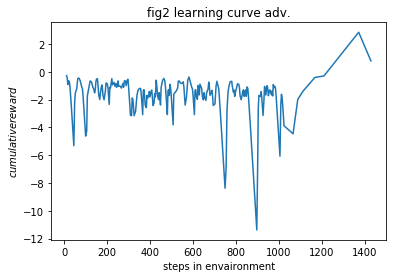

In [9]:
plt.title("fig2 learning curve adv.")
plt.xlabel("steps in envaironment")
plt.ylabel("$cumulative reward$")
plt.plot(learning_curve_adv[0],learning_curve_adv[1])
plt.show()

# Conclusion
 
今度は学習がうまくいってる．また，終了することでstep数が抑えられ，非常に早く学習が終了する．step数を抑えることで，累積したマイナスの報酬が抑えられ，成功報酬の+1が有効に機能している．終了行動のない場合は累積したマイナスの報酬があまりにも大きな値になり，成功報酬+1と比較して相対的にほとんど効果をなしていなかった．その点こちらはこの効果が反映され学習にいい影響を及ぼしていると考えられる．